For information on tree-based machine learning methods. Read Chapter 8 of "An Introduction to Statistical Learning: with applications in Python". Available free of charge at: https://www.statlearning.com. Youtube channel with videos about the chapters available at: http://y2u.be/QNnayf--_yk

# IMPORTS

In [1]:
import pandas as pd
import numpy as np
import re

import openpyxl

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.patches as patches
from matplotlib.ticker import MultipleLocator
import matplotlib.ticker as ticker
import seaborn as sns
import sklearn
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, export_text, export_graphviz
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, KFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import log_loss, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import VarianceThreshold
import graphviz


from IPython.display import display
import pickle
random_state = 1
matplotlib.rcParams['font.family'] = 'Arial'
matplotlib.rcParams['font.size'] = 10

pd.set_option('display.max_rows', 5)
pd.set_option('display.max_columns', None)

# HELPER FUNCTIONS

In [2]:
#---------------------------------------------------------------------------------------------#
# FUNCTION TO PROCESS THE INITIAL DATAFRAME AND ADD THE CORRECT HEADERS:

def process_dataframe(input_df):
    """
    Process a dataframe by combining adjacent non-null cells in the first two rows.

    Parameters:
    - input_df: DataFrame to be processed.

    Returns:
    - processed_df: Processed DataFrame with updated column names and removed first two rows.
    """
    # Create a copy of the input dataframe to avoid modifying the original
    processed_df = input_df.copy()

    # List to store new column names
    new_columns = []

    # Iterate through pairs of values in the first two rows
    for col1, col2 in zip(processed_df.iloc[0], processed_df.iloc[1]):
        if pd.isna(col1):
            new_columns.append(col2)
        else:
            new_columns.append(f"{col1}_{col2}")

    # Update column names in the processed dataframe
    processed_df.columns = new_columns

    # Drop the first two rows
    processed_df.drop([0, 1], inplace=True)

    # Reset the index
    processed_df.reset_index(drop=True, inplace=True)

    return processed_df

#---------------------------------------------------------------------------------------------#
# FUNCTION TO NORMALIZE THE DATAFRAME AND DELETE COLUMNS WITH LOW VARIANCE: 

def normalize_dataframe(dataframe, variance_threshold=0.0):
    """
    Normalize specified columns in the dataframe and perform variance-based feature selection.

    Parameters:
    - dataframe: DataFrame to be normalized.
    - variance_threshold: Threshold for variance-based feature selection.

    Returns:
    - normalized_df: DataFrame with specified columns normalized and features selected based on variance.
    """
    # Create a copy of the dataframe to avoid modifying the original
    normalized_df = dataframe.copy()

    # Select columns to normalize (starting from prop_start_index)
    columns_to_normalize = dataframe.columns[prop_start_index:]

    # Use Min-Max scaling to normalize the selected columns
    scaler = MinMaxScaler()
    normalized_df[columns_to_normalize] = scaler.fit_transform(dataframe[columns_to_normalize])

    # Use VarianceThreshold for feature selection based on variance
    selector = VarianceThreshold(threshold=variance_threshold)
    selected_columns = selector.fit_transform(normalized_df[columns_to_normalize])

    # Update the normalized dataframe with the selected columns
    normalized_df = normalized_df.iloc[:, :prop_start_index].join(pd.DataFrame(selected_columns, columns=columns_to_normalize[selector.get_support()]))

    return normalized_df

#---------------------------------------------------------------------------------------------#
# FUNCTION TO FIND CORRELATED PAIRS: 

def correlated_pairs(dataframe, threshold=0.95):
    """
    Identify highly correlated column pairs in a dataframe.

    Parameters:
    - dataframe: DataFrame to analyze.
    - threshold: Threshold for correlation coefficient to consider pairs as highly correlated.

    Returns:
    - None: Prints correlated column pairs and returns None.
    """
    # Calculate the absolute correlation matrix
    df_corr = dataframe.corr().abs()

    # Create an upper triangular matrix to avoid duplicates in pairs
    upper = df_corr.where(np.triu(np.ones(df_corr.shape), k=1).astype(bool))

    # List to store correlated column pairs
    correlated_pairs = []

    # Iterate through columns to find correlated pairs
    for col1 in upper.columns:
        for col2 in upper.columns:
            if col1 != col2 and upper[col1][col2] > threshold:
                correlated_pairs.append((col1, col2))

    # Print the correlated pairs
    if correlated_pairs:
        print(f"Highly correlated column pairs with a correlation coefficient above {threshold}:")
        for col1, col2 in correlated_pairs:
            print(f"Correlated Pair: {col1} : {col2}")
    else:
        print("No highly correlated column pairs found.")

    return None


#---------------------------------------------------------------------------------------------#
# FUNCTION TO DROP COLUMNS:

def drop_columns(dataframe, substrings):
    """
    Drop columns from a dataframe based on the presence of specified substrings.

    Parameters:
    - dataframe: DataFrame to drop columns from.
    - substrings: List of substrings to search for in column names.

    Returns:
    - dataframe: DataFrame with specified columns dropped.
    """
    # Identify columns containing specified substrings
    columns_to_drop = [col for col in dataframe.columns if any(substring in col for substring in substrings)]

    # Drop the identified columns
    return dataframe.drop(columns=columns_to_drop)


#---------------------------------------------------------------------------------------------#
# FUNCTION TO PLOT THE DECISION TREE

def plot_decision_tree(model, X_labelname, class_names=None):
    """
    Plot the decision tree model.

    Parameters:
    - model: Decision tree model to be plotted.
    - X_labelname: Feature names used in the model.
    - class_names: Names of classes for classification models.

    Returns:
    - graph: Graphviz object representing the decision tree.
    """
    # Generate DOT data for the decision tree
    dot_data = export_graphviz(model, out_file=None,
                               feature_names=X_labelname,
                               class_names=class_names,
                               filled=True, 
                               rounded=True,
                               special_characters=True)

    # Create a Graphviz object from the DOT data
    graph = graphviz.Source(dot_data)

    return graph

# LOADING DATASET

Enter the name of your excel file and sheet containing your data. 

In [3]:
# Change excel file name and sheet: 

excel = "MP_data"
expt_sheet = "SF_qikprop_all"

###############
load_df = pd.read_excel(excel + ".xlsx", expt_sheet, header=None, engine='openpyxl')

initial_df = process_dataframe(load_df)

prop_start = next((col for col in initial_df.columns if col.startswith("x1_")), None)
prop_start_index = initial_df.columns.get_loc(prop_start)
display(initial_df)

,ID,SMILES,sf_inchi,sf_mp_average,#amine,#amidine,#acid,#amide,#rotor,#rtvFG,CNS,x1_mol MW,x2_dipole,x3_SASA,x4_FOSA,x5_FISA,x6_PISA,x7_WPSA,x8_volume,x9_donorHB,x10_accptHB,x11_dip^2/V,x12_ACxDN^.5/SA,x13_glob,x14_QPpolrz,x15_QPlogPC16,x16_QPlogPoct,x17_QPlogPw,x18_QPlogPo/w,x19_QPlogS,x20_CIQPlogS,x21_QPlogHERG,x22_QPPCaco,x23_QPlogBB,x24_QPPMDCK,x25_QPlogKp,x26_IP(eV),x27_EA(eV),x28_#metab,x29_QPlogKhsa,x30_HumanOralAbsorption,x31_PercentHumanOralAbsorption,x32_SAfluorine,x33_SAamideO,x34_PSA,x35_#NandO,x36_RuleOfFive,x37_RuleOfThree,x38_#ringatoms,x39_#in34,x40_#in56,x41_#noncon,x42_#nonHatm,x43_Jm
0,4000,Cc1ccc(S(=O)(=O)F)cc1,"InChI=1S/C7H7FO2S/c1-6-2-4-7(5-3-6)11(8,9)10/h...",41,0,0,0,0,1,1,0,174.19,7.867,364.464,88.808,85.694,139.536,50.425,563.077,0,4,0.1099,0,0.904807,17.071,4.683,8.905,5.865,0.671,-1.086,-1.276,-3.738,1524.968,-0.071,1474.551,-2.511,10.694,1.317,1,-0.86,3,87.847,49.536,0,39.427,2,0,0,6,0,6,0,11,43.989
1,1,Nc1ccc(S(=O)(=O)F)cc1,"InChI=1S/C6H6FNO2S/c7-11(9,10)6-3-1-5(8)2-4-6/...",70.5,0,0,0,0,2,1,-1,175.177,9.163,348.494,0,147.846,149.802,50.846,534.462,1.5,5,0.157102,0.017572,0.913933,15.382,5.31,11.993,9.281,0.078,-1.519,-1.382,-3.639,392.535,-0.612,341.912,-3.525,9.39,1.237,1,-0.768,3,73.828,49.873,0,66.297,3,0,0,6,0,6,0,11,2.922
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
719,781,CC(C)(C)c1cc([Si](C)(C)C)c(S(=O)(=O)F)c([Si](C...,"InChI=1S/C16H29FO2SSi2/c1-16(2,3)12-10-13(21(4...",132,0,0,0,0,4,1,1,360.633,6.619,597.333,532.555,33.933,7.85,22.995,1133.32,0,4,0.038652,0,0.88007,36.708,8.975,14.171,4.507,4.603,-4.891,-5.236,-3.51,4721.896,0.087,3539.604,-1.733,9.56,1.174,0,0.668,3,100,22.933,0,27.438,2,0,0,6,0,6,0,22,0.086
720,782,COc1cc([Si](C)(C)C)c(S(=O)(=O)F)cc1[Si](C)(C)C,"InChI=1S/C13H23FO3SSi2/c1-17-10-8-13(20(5,6)7)...",90.5,0,0,0,0,4,1,0,334.552,7.423,576.389,463.86,50.342,18.328,43.859,1046.623,0,4.75,0.052646,0,0.864921,33.338,8.213,13.706,5.385,3.65,-4.193,-4.334,-3.805,3299.972,-0.019,3126.489,-1.999,9.669,0.988,1,0.216,3,100,42.314,0,35.077,3,0,0,6,0,6,0,20,0.215


## DROP COLUMNS WITH NAN

In [4]:
expt_df = initial_df.copy()
nan_columns = expt_df.columns[expt_df.isna().any()]
print(f"These columns have missing values: {nan_columns[0]}")
expt_df = expt_df.drop(columns=nan_columns)
expt_df = expt_df.reset_index(drop=True)

#Note: if IndexError ocurrs, no columns have missing values ('nan')

IndexError: index 0 is out of bounds for axis 0 with size 0

## CLEANING DATAFRAME

Utilize the 'filter_1' parameter to exclude specific columns based on your requirements. This feature may be valuable when aiming for interpretable and explainable models. This cell is also used to remove features with low variance. Change the "variance_threshold" according to your needs.

In [5]:
# FILTER UNINTERPRETABLE OR REPEATITIVE FEATURES

filter_1 = [] #delete any columns 'x1', 'x2' (...)
data_filtered = drop_columns(expt_df, filter_1)

# NORMALIZE DATAFRAME AND REMOVE COLUMNS WITH LOW VARIANCE

variance_threshold = 0.0

data_norm = normalize_dataframe(expt_df, variance_threshold=variance_threshold)
display(data_norm)

,ID,SMILES,sf_inchi,sf_mp_average,#amine,#amidine,#acid,#amide,#rotor,#rtvFG,CNS,x1_mol MW,x2_dipole,x3_SASA,x4_FOSA,x5_FISA,x6_PISA,x7_WPSA,x8_volume,x9_donorHB,x10_accptHB,x11_dip^2/V,x12_ACxDN^.5/SA,x13_glob,x14_QPpolrz,x15_QPlogPC16,x16_QPlogPoct,x17_QPlogPw,x18_QPlogPo/w,x19_QPlogS,x20_CIQPlogS,x21_QPlogHERG,x22_QPPCaco,x23_QPlogBB,x24_QPPMDCK,x25_QPlogKp,x26_IP(eV),x27_EA(eV),x28_#metab,x29_QPlogKhsa,x30_HumanOralAbsorption,x31_PercentHumanOralAbsorption,x32_SAfluorine,x33_SAamideO,x34_PSA,x35_#NandO,x36_RuleOfFive,x37_RuleOfThree,x38_#ringatoms,x39_#in34,x40_#in56,x41_#noncon,x42_#nonHatm,x43_Jm
0,4000,Cc1ccc(S(=O)(=O)F)cc1,"InChI=1S/C7H7FO2S/c1-6-2-4-7(5-3-6)11(8,9)10/h...",41,0,0,0,0,1,1,0,0.068125,0.388045,0.116190,0.155461,0.173368,0.254722,0.092841,0.118003,0.000000,0.000000,0.380601,0.000000,0.679043,0.154648,0.104626,0.022751,0.068524,0.459593,0.677230,0.816088,0.606654,0.304116,0.846014,0.147436,0.833915,0.673569,0.174508,0.125,0.551420,1.0,0.87847,0.091304,0.0,0.079473,0.000000,0.0,0.0,0.047619,0.0,0.047619,0.0,0.076923,0.016941
1,1,Nc1ccc(S(=O)(=O)F)cc1,"InChI=1S/C6H6FNO2S/c7-11(9,10)6-3-1-5(8)2-4-6/...",70.5,0,0,0,0,2,1,-1,0.070919,0.458857,0.088275,0.000000,0.371052,0.274579,0.094136,0.092320,0.214286,0.077519,0.545458,0.427249,0.714322,0.110976,0.150661,0.149106,0.240892,0.395782,0.631942,0.802889,0.621557,0.078232,0.723505,0.034169,0.697771,0.436694,0.146419,0.125,0.576785,1.0,0.73828,0.092345,0.0,0.238467,0.090909,0.0,0.0,0.047619,0.0,0.047619,0.0,0.076923,0.001125
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
719,781,CC(C)(C)c1cc([Si](C)(C)C)c(S(=O)(=O)F)c([Si](C...,"InChI=1S/C16H29FO2SSi2/c1-16(2,3)12-10-13(21(4...",132,0,0,0,0,4,1,1,0.595965,0.319856,0.523236,0.932251,0.008734,0.000000,0.008429,0.629827,0.000000,0.000000,0.131761,0.000000,0.583415,0.662392,0.419750,0.238226,0.000000,0.882707,0.279259,0.322998,0.640975,0.941800,0.881793,0.353946,0.938373,0.467575,0.124298,0.000,0.972705,1.0,1.00000,0.009097,0.0,0.008533,0.000000,0.0,0.0,0.047619,0.0,0.047619,0.0,0.500000,0.000033
720,782,COc1cc([Si](C)(C)C)c(S(=O)(=O)F)cc1[Si](C)(C)C,"InChI=1S/C13H23FO3SSi2/c1-17-10-8-13(20(5,6)7)...",90.5,0,0,0,0,4,1,0,0.522126,0.363785,0.486626,0.811999,0.060925,0.020268,0.072635,0.552012,0.000000,0.058140,0.180638,0.000000,0.524851,0.575255,0.363803,0.219199,0.044303,0.780157,0.352264,0.435313,0.596568,0.658172,0.857790,0.312633,0.902658,0.487375,0.058989,0.125,0.848084,1.0,1.00000,0.068987,0.0,0.053734,0.090909,0.0,0.0,0.047619,0.0,0.047619,0.0,0.423077,0.000083


### FINDING AND REMOVING CORRELATED COLUMNS

This cell is designed to eliminate correlated features based on the specified threshold. Adjust the 'correlation_threshold' according to your requirements. Upon execution, a list of correlated features will be printed. Use the 'filter_2' parameter to manually exclude columns with high correlation. This process can be iteratively performed. Subsequently, a second list will be printed, displaying correlated features in the cleaned dataframe.

In [8]:
# Choose correlation threshold: 
correlation_threshold = 0.95

correlated_pairs(data_norm, threshold=correlation_threshold)

print('--------------------------------------')

# Manually enter the correlated columns you want to remove:
#filter_2 = ['x12', 'x18'] 

data_clean = drop_columns(data_norm, filter_2)
correlated_pairs(data_clean, threshold=correlation_threshold)

Highly correlated column pairs with a correlation coefficient above 0.95:
Correlated Pair: x8_volume : x3_SASA
Correlated Pair: x13_glob : x3_SASA
Correlated Pair: x14_QPpolrz : x3_SASA
Correlated Pair: x14_QPpolrz : x8_volume
Correlated Pair: x15_QPlogPC16 : x3_SASA
Correlated Pair: x15_QPlogPC16 : x8_volume
Correlated Pair: x15_QPlogPC16 : x14_QPpolrz
Correlated Pair: x40_#in56 : x38_#ringatoms
Correlated Pair: x42_#nonHatm : x1_mol MW
Correlated Pair: x42_#nonHatm : x3_SASA
Correlated Pair: x42_#nonHatm : x8_volume
Correlated Pair: x42_#nonHatm : x14_QPpolrz
Correlated Pair: x42_#nonHatm : x15_QPlogPC16
--------------------------------------
Highly correlated column pairs with a correlation coefficient above 0.95:
Correlated Pair: x8_volume : x3_SASA
Correlated Pair: x13_glob : x3_SASA
Correlated Pair: x14_QPpolrz : x3_SASA
Correlated Pair: x14_QPpolrz : x8_volume
Correlated Pair: x15_QPlogPC16 : x3_SASA
Correlated Pair: x15_QPlogPC16 : x8_volume
Correlated Pair: x15_QPlogPC16 : x14

## CLEANED DATAFRAME

In [10]:
common_columns = expt_df.columns.intersection(data_clean.columns)
final_data = expt_df[common_columns]
display(final_data)

,ID,SMILES,sf_inchi,sf_mp_average,#amine,#amidine,#acid,#amide,#rotor,#rtvFG,CNS,x1_mol MW,x2_dipole,x3_SASA,x4_FOSA,x5_FISA,x6_PISA,x7_WPSA,x8_volume,x9_donorHB,x10_accptHB,x11_dip^2/V,x13_glob,x14_QPpolrz,x15_QPlogPC16,x16_QPlogPoct,x17_QPlogPw,x19_QPlogS,x20_CIQPlogS,x21_QPlogHERG,x22_QPPCaco,x23_QPlogBB,x24_QPPMDCK,x25_QPlogKp,x26_IP(eV),x27_EA(eV),x28_#metab,x29_QPlogKhsa,x30_HumanOralAbsorption,x31_PercentHumanOralAbsorption,x32_SAfluorine,x33_SAamideO,x34_PSA,x35_#NandO,x36_RuleOfFive,x37_RuleOfThree,x38_#ringatoms,x39_#in34,x40_#in56,x41_#noncon,x42_#nonHatm,x43_Jm
0,4000,Cc1ccc(S(=O)(=O)F)cc1,"InChI=1S/C7H7FO2S/c1-6-2-4-7(5-3-6)11(8,9)10/h...",41,0,0,0,0,1,1,0,174.19,7.867,364.464,88.808,85.694,139.536,50.425,563.077,0,4,0.1099,0.904807,17.071,4.683,8.905,5.865,-1.086,-1.276,-3.738,1524.968,-0.071,1474.551,-2.511,10.694,1.317,1,-0.86,3,87.847,49.536,0,39.427,2,0,0,6,0,6,0,11,43.989
1,1,Nc1ccc(S(=O)(=O)F)cc1,"InChI=1S/C6H6FNO2S/c7-11(9,10)6-3-1-5(8)2-4-6/...",70.5,0,0,0,0,2,1,-1,175.177,9.163,348.494,0,147.846,149.802,50.846,534.462,1.5,5,0.157102,0.913933,15.382,5.31,11.993,9.281,-1.519,-1.382,-3.639,392.535,-0.612,341.912,-3.525,9.39,1.237,1,-0.768,3,73.828,49.873,0,66.297,3,0,0,6,0,6,0,11,2.922
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
719,781,CC(C)(C)c1cc([Si](C)(C)C)c(S(=O)(=O)F)c([Si](C...,"InChI=1S/C16H29FO2SSi2/c1-16(2,3)12-10-13(21(4...",132,0,0,0,0,4,1,1,360.633,6.619,597.333,532.555,33.933,7.85,22.995,1133.32,0,4,0.038652,0.88007,36.708,8.975,14.171,4.507,-4.891,-5.236,-3.51,4721.896,0.087,3539.604,-1.733,9.56,1.174,0,0.668,3,100,22.933,0,27.438,2,0,0,6,0,6,0,22,0.086
720,782,COc1cc([Si](C)(C)C)c(S(=O)(=O)F)cc1[Si](C)(C)C,"InChI=1S/C13H23FO3SSi2/c1-17-10-8-13(20(5,6)7)...",90.5,0,0,0,0,4,1,0,334.552,7.423,576.389,463.86,50.342,18.328,43.859,1046.623,0,4.75,0.052646,0.864921,33.338,8.213,13.706,5.385,-4.193,-4.334,-3.805,3299.972,-0.019,3126.489,-1.999,9.669,0.988,1,0.216,3,100,42.314,0,35.077,3,0,0,6,0,6,0,20,0.215


# DECISION TREE

## DECISION TREE CLASSIFIER

### SELECTING THRESHOLDS

Class 0: 104 values
Class 1: 617 values
Recomended class weights: {0: 6, 1: 1}


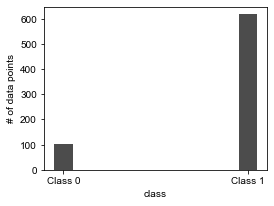

In [11]:
# enter your training dataframe: 

data = final_data.copy()

# enter the name of your response column: 

response = "sf_mp_average"

# enter the cutoff you want: 

cutoffs = {
    'cutoff_1': 70,
    'cutoff_2': None,
    'cutoff_3': None,  # Enter a new class if needed
    'cutoff_4': None,  # Enter a new class if needed
    'cutoff_5': None,  # Enter a new class if needed
}

################## no changes below here ######################

pattern = r'^x([1-9]\d{0,2}|1000)_'
properties_start = next((col for col in data.columns if re.match(pattern, col)), None)
properties_start_idx = data.columns.get_loc(properties_start)


X = data.iloc[:,properties_start_idx:].values
y = data[response]

## cutoffs:

cutoff_values = [value for value in cutoffs.values() if value is not None]
cutoff_values.sort()

# Create y_class based on the sorted cutoffs
y_class = []
for i in y:
    for idx, cutoff in enumerate(cutoff_values):
        if i < cutoff:
            y_class.append(idx)
            break
    else:
        # If the value doesn't match any cutoff, assign it to the last class
        y_class.append(len(cutoff_values))

y_class = np.array(y_class)
y_class = y_class.astype(int)
X_labelname = data.columns[properties_start_idx:].tolist()


class_counts = np.bincount(y_class)

# Print the number of values in each class
for class_num, count in enumerate(class_counts):
    print(f"Class {class_num}: {count} values")

    
###
max_count = np.max(class_counts)
ratios = {i: int(round(max_count / count)) for i, count in enumerate(class_counts)}
print(f"Recomended class weights: {ratios}")


# Plot the class counts as a histogram
plt.figure(figsize=(4, 3))
plt.bar(range(len(class_counts)), class_counts, width=0.1, color='black', label='Test set', alpha=0.7)
plt.xlabel("class")
plt.ylabel("# of data points")
plt.xticks(range(len(class_counts)), [f"Class {class_num}" for class_num in range(len(class_counts))])

plt.show()

### COST COMPLEXITY PRUNING

#### SELECTING TRAIN/TEST SPLIT

Training set:
Class 0: 69 values
Class 1: 435 values
Test set:
Class 0: 35 values
Class 1: 182 values


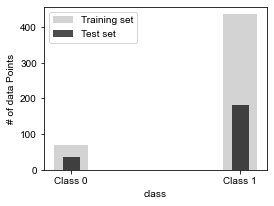

In [14]:
# enteer the test size: 
test_size = 0.30

#---------------------------------------------------------------------------------------------#
X_train, X_test, y_train, y_test = train_test_split(X, y_class, test_size=test_size, shuffle=True, random_state=random_state)

train_count = np.bincount(y_train)
test_count = np.bincount(y_test)

# Print the number of values in each class
print("Training set:")
for class_num, count in enumerate(train_count):
    print(f"Class {class_num}: {count} values")
print("Test set:")
for class_num, count in enumerate(test_count):
    print(f"Class {class_num}: {count} values")

# Plot the bars on top of each other
plt.figure(figsize=(4, 3))
plt.bar(np.arange(len(train_count)), train_count, width=0.2, color='lightgrey', label='Training set')
plt.bar(np.arange(len(test_count)), test_count, width=0.1, color='black', label='Test set', alpha=0.7)

plt.xlabel("class")
plt.ylabel("# of data Points")
plt.xticks(range(len(class_counts)), [f"Class {class_num}" for class_num in range(len(class_counts))])
plt.legend()
plt.savefig("train-val_distribution.png", dpi=600, bbox_inches='tight')
plt.show()

#### OPTIMZING DT SIZE

This section aims to optimize the complexity of the decision tree by tuning the alpha parameter, which controls the trade-off between accuracy in the training set and cross-validation set. A lower alpha value corresponds to a higher complexity tree. The goal is to identify the optimal alpha that results in the highest accuracy for both the training and cross-validation sets. Achieving this balance ensures that the decision tree is appropriately complex, capturing patterns in the data without overfitting to the training set.

The alpha with the highest cross-validation score is: 0.009307285859712057


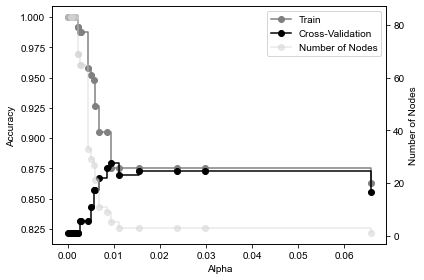

In [15]:
# enter the kfold splits:
kfold_splits = 5

# enter the class weights: 
class_weight= {0: 12, 1: 1}

#---------------------------------------------------------------------------------------------#

dt_p = DecisionTreeClassifier(random_state=random_state,
                             class_weight=class_weight)

path = dt_p.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

clfs = []
for ccp_alpha in ccp_alphas:
    dt_p = DecisionTreeClassifier(random_state=random_state, ccp_alpha=ccp_alpha)
    dt_p.fit(X_train, y_train)
    clfs.append(dt_p)

# Compute training scores
train_scores = [clf.score(X_train, y_train) for clf in clfs]

# Perform cross-validation on the training set
cv_scores = []
for ccp_alpha in ccp_alphas:
    dt_cv = DecisionTreeClassifier(random_state=random_state, ccp_alpha=ccp_alpha)
    scores = cross_val_score(dt_cv, X_train, y_train, cv=kfold_splits)  
    cv_scores.append(np.mean(scores))

# Find the index of the maximum cross-validation score
best_alpha_index = np.argmax(cv_scores)

# Get the corresponding alpha value
best_alpha = ccp_alphas[best_alpha_index]

# Print the result
print(f"The alpha with the highest cross-validation score is: {best_alpha}")

# Plotting with dual y-axes
fig, ax1 = plt.subplots()

ax1.set_xlabel("Alpha")
ax1.set_ylabel("Accuracy", color="black")
line1, = ax1.plot(ccp_alphas[:-1], train_scores[:-1], marker="o", label="Train", drawstyle="steps-post", color="gray")
line2, = ax1.plot(ccp_alphas[:-1], cv_scores[:-1], marker="o", label="Cross-Validation", drawstyle="steps-post", color="black")

ax2 = ax1.twinx()
ax2.set_ylabel("Number of Nodes")
line3, = ax2.plot(ccp_alphas[:-1], [clf.tree_.node_count for clf in clfs[:-1]], marker="o", alpha=0.5, label="Number of Nodes", drawstyle="steps-post", color="lightgrey")
ax2.tick_params(axis="y")

lines = [line1, line2, line3]
labels = [line.get_label() for line in lines]
ax1.legend(lines, labels, loc="upper right")

fig.tight_layout()
plt.savefig("alpha.png", dpi=600, bbox_inches='tight')
plt.show()

### OPTIMIZED CLASSIFICATION DECISION TREE

This is will train a decision tree classifier with optimized alpha. Test accuracy as well confusion matrix for the test set and each cross-validation folder will be generated in the following cells. 

Accuracy on the test set: 0.81
Precision on the test set: 0.88
Recall on the test set: 0.82
F1 Score on the test set: 0.73


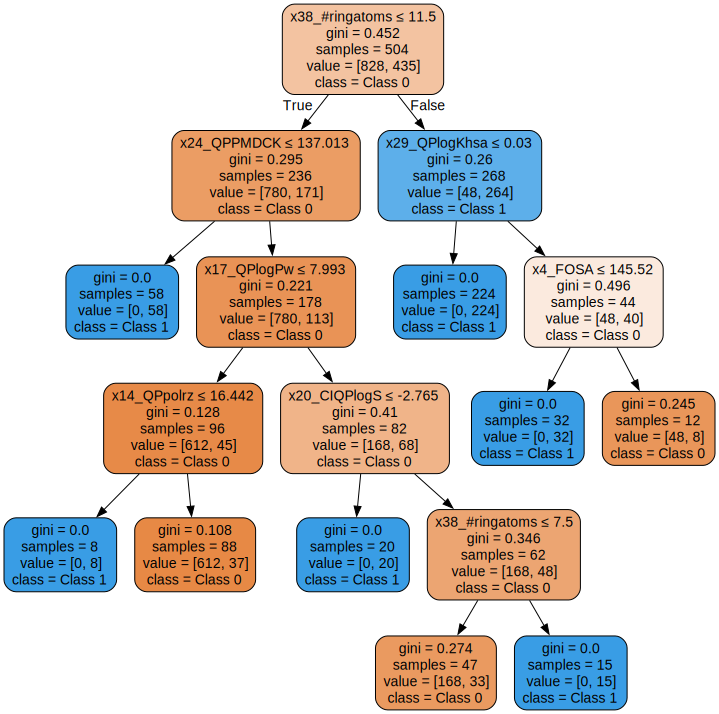

In [19]:
model_final = DecisionTreeClassifier(random_state=random_state,
                               ccp_alpha=best_alpha,
                               criterion='gini',
                               class_weight=class_weight, 
                               max_depth=5) 
#####################################
model_final.fit(X_train, y_train)
y_pred = model_final.predict(X_test)

#####################################
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred,average='weighted')
recall = recall_score(y_test, y_pred,average='macro')
f1 = f1_score(y_test, y_pred,average='macro')

print("Accuracy on the test set: {:.2f}".format(accuracy))
print("Precision on the test set: {:.2f}".format(precision))
print("Recall on the test set: {:.2f}".format(recall))
print("F1 Score on the test set: {:.2f}".format(f1))
#####################################
class_names = [f'Class {class_num}' for class_num, count in enumerate(class_counts)]


graph.render("Decision_tree")
graph = plot_decision_tree(model_final, X_labelname, class_names)
graph  # To save the plot to a file, use graph.render("SH_descriptors_training_set") #or graph.view()

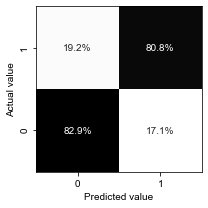

In [20]:
#Confusion Matrix
fig, ax = plt.subplots(figsize=(3,3))
cm = confusion_matrix(y_test, y_pred, normalize='true')
cm = np.flipud(cm)

yticklabels = ([f'{class_num}' for class_num, count in enumerate(class_counts)])
xticklabels = ([f'{class_num}' for class_num, count in enumerate(class_counts)])
res = sns.heatmap(cm, annot=True, cmap='Greys', fmt='.1%',cbar=False, yticklabels=yticklabels[::-1], xticklabels=xticklabels)
for _, spine in res.spines.items():
    spine.set_visible(True)
    spine.set_linewidth(0.75)
    
ax.set_xlabel('Predicted value')
ax.set_ylabel('Actual value')
ax.set_xticks(np.arange(len(class_counts)) + 0.5)
ax.set_yticks(np.arange(len(class_counts)) + 0.5)

fig.tight_layout()
fig.savefig("confusion_matrix.png", dpi=600, bbox_inches='tight')
plt.show()
#####################################

Average cross-validation score: 0.80


,fit_time,score_time,test_score,train_score
0,0.000000,0.0,0.806897,0.842014
1,0.015630,0.0,0.812500,0.802426
2,0.015621,0.0,0.812500,0.854419
3,0.000000,0.0,0.819444,0.847487
4,0.011588,0.0,0.770833,0.868284


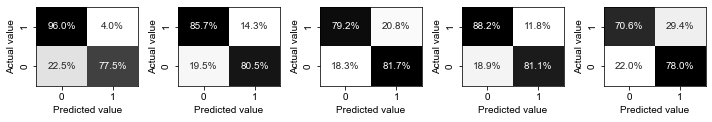

In [15]:
#K-fold cross validation confusion matrices 
kfold = KFold(n_splits=5, shuffle=True, random_state=random_state)
scores = cross_val_score(model_final, X, y_class, cv=kfold)
average_score = scores.mean()
scores_new = cross_validate(model_final, X, y_class, cv=kfold, return_train_score = True)
print("Average cross-validation score: {:.2f}".format(average_score))
display(pd.DataFrame(scores_new))
#####################################
confusion_matrices = []
# Perform k-fold cross-validation
for train_idx, test_idx in kfold.split(X):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y_class[train_idx], y_class[test_idx]

    # Train your model on the training data
    model_final.fit(X_train, y_train)

    # Make predictions on the test data
    y_pred = model_final.predict(X_test)

    # Calculate the confusion matrix for this fold
    cm = confusion_matrix(y_test, y_pred, normalize='true')

    # Append the confusion matrix to the list
    confusion_matrices.append(cm)
#####################################
# Create a figure with subplots in a single row
fig, axes = plt.subplots(1, len(confusion_matrices), figsize=(2 * len(confusion_matrices), 1.8))
yticklabels = ([f'{class_num}' for class_num, count in enumerate(class_counts)])
xticklabels = ([f'{class_num}' for class_num, count in enumerate(class_counts)])
# Enumerate over the confusion matrices and plot them in the subplots
for i, cm in enumerate(confusion_matrices):
    ax = axes[i]
    res = sns.heatmap(cm, annot=True, cmap='Greys', fmt='.1%', cbar=False, yticklabels=yticklabels[::-1], xticklabels=xticklabels, ax=ax)
    for _, spine in res.spines.items():
        spine.set_visible(True)
        spine.set_linewidth(0.75)

    ax.set_xlabel('Predicted value')
    ax.set_ylabel('Actual value')
    ax.set_xticks(np.arange(len(class_counts)) + 0.5)
    ax.set_yticks(np.arange(len(class_counts)) + 0.5)

fig.tight_layout()
plt.show()

### EXPORT DT

In [16]:
#### NEED TO MAKE A NEW DF WITH THREE FEATURES ONLY

filename = 'dt_model.pkl'
with open(filename, 'wb') as file:
     pickle.dump(model_final, file)